## Interpolation of EC to Sampling Points

This notebook predicts EC values (EC30, EC90) from the EC survey points to the soil depth sampling points using:
- IDW (Inverse Distance Weighting)
- k-NN (mean of k nearest neighbors; equivalent to idp = 0 in R's gstat)
- Ordinary Kriging (optional, if PyKrige is installed)

We use the F05 datasets:
- `F05_EC_2009.gpkg` as training points (EC30/EC90)
- `F05_hardpan.gpkg` as target points (soil sampling locations)

Outputs:
- Sampling points with interpolated EC attributes
- Plots


In [1]:
pip install geopandas rasterio matplotlib pykrige scipy 

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Setup and imports
import warnings
warnings.filterwarnings("ignore")

# Numeric and data handling
import numpy as np
import pandas as pd

# Geospatial
import geopandas as gpd
from shapely.geometry import Point

# Nearest neighbors
from scipy.spatial import cKDTree
from typing import Optional

# Plotting
import matplotlib.pyplot as plt

# Optional kriging; install pykrige to enable OK
try:
    from pykrige.ok import OrdinaryKriging
    _HAS_PYKRIGE = True
except Exception:
    _HAS_PYKRIGE = False

print("PyKrige available:", _HAS_PYKRIGE)


PyKrige available: True


### Data paths
Adjust if your files are elsewhere. This notebook assumes the workspace layout you have open.


In [5]:
from pathlib import Path

# Absolute project directory path
DATA_DIR = Path("..") / "data"

PATH_EC  = DATA_DIR / "F05_EC_2009.gpkg"
print(PATH_EC)
PATH_HP  = DATA_DIR / "F05_hardpan.gpkg"
PATH_BND = DATA_DIR / "F05_boundary.gpkg"

for p in [PATH_EC, PATH_HP, PATH_BND]:
    print(p.name, "exists:", p.exists())


../data/F05_EC_2009.gpkg
F05_EC_2009.gpkg exists: True
F05_hardpan.gpkg exists: True
F05_boundary.gpkg exists: True


### Load data and ensure CRS alignment
- Load EC survey points and soil depth sampling points
- Reproject to a common CRS if needed (use EC CRS as reference)


In [6]:
# Load layers
ec = gpd.read_file(PATH_EC)
hp = gpd.read_file(PATH_HP)

print("EC columns:", list(ec.columns))
print("HP columns:", list(hp.columns))
print("CRS EC:", ec.crs)
print("CRS HP:", hp.crs)

# Align CRS to EC's CRS if necessary
if hp.crs != ec.crs:
    hp = hp.to_crs(ec.crs)
    print("Reprojected HP to:", hp.crs)

EC columns: ['EC30', 'EC90', 'geometry']
HP columns: ['hpdepth', 'geometry']
CRS EC: EPSG:32721
CRS HP: EPSG:32721


### Prepare training and query arrays
- Training locations: EC points (assumed columns EC30 and EC90)
- Query locations: hardpan points
- Drop rows with missing EC before fitting


In [7]:
# Identify EC value columns
if {"EC30", "EC90"}.issubset(ec.columns):
    ec_vals = ec[["EC30", "EC90"]].astype(float)
else:
    # Fallback: use first two numeric columns
    num_cols = ec.select_dtypes(include=[np.number]).columns
    if len(num_cols) < 2:
        raise ValueError("Could not find EC30/EC90 or at least two numeric columns in EC layer.")
    ec_vals = ec[num_cols[:2]].astype(float)
    ec_vals.columns = ["EC30", "EC90"]

# Remove rows with NA values in targets for interpolation
valid_mask = ec_vals.notna().all(axis=1)
ec_train = ec[valid_mask].reset_index(drop=True)
ec_vals = ec_vals[valid_mask].reset_index(drop=True)

# Build arrays
# train_xy: 2D array of training coordinates from ec_train.geometry (x, y).
# train_ec30, train_ec90: 1D arrays of target values.
train_xy = np.column_stack([ec_train.geometry.x.values, ec_train.geometry.y.values])
train_ec30 = ec_vals["EC30"].values
train_ec90 = ec_vals["EC90"].values
# query_xy from hp.geometry (x, y) — these are the locations where we will predict/interpolate.
query_xy = np.column_stack([hp.geometry.x.values, hp.geometry.y.values])
print("Train n:", train_xy.shape[0], "Query n:", query_xy.shape[0])

Train n: 3039 Query n: 114


### IDW (Inverse Distance Weighting)
We implement IDW using cKDTree for efficiency. If a query coincides with a training point, we return the exact value.


In [8]:
def idw_predict(train_xy: np.ndarray, train_vals: np.ndarray, query_xy: np.ndarray,
                 power: float = 2.0, nmax: Optional[int] = 16) -> np.ndarray:
    """Predict values at query_xy using IDW.
    - train_xy: (n,2) coordinates for training
    - train_vals: (n,) values
    - query_xy: (m,2) coordinates to predict
    - power: distance decay parameter (2 is common)
    - nmax: number of nearest neighbors to use (default 16, change it as needed)
    """ 
    tree = cKDTree(train_xy) #Builds a k-dimentional tree from train_xy
    dists, idxs = tree.query(query_xy, k=nmax) # For each query point, finds nmax nearest training points.
    #If any neighbor is at distance 0, returns that exact training value.
    #Otherwise computes weights wi = 1 / d^power and returns the weighted average.
    dists = np.atleast_2d(dists)
    idxs = np.atleast_2d(idxs)
    preds = np.empty(query_xy.shape[0], dtype=float)
    #returns an array of predictions, one per query point.
    for i in range(query_xy.shape[0]):
        di = dists[i]
        ii = idxs[i]
        if np.any(di == 0):
            # Exact hit
            preds[i] = train_vals[ii[di == 0][0]]
        else:
            wi = 1.0 / (di ** power)
            preds[i] = float(np.sum(wi * train_vals[ii]) / np.sum(wi))
    return preds

# Predict EC30 and EC90 via IDW
hp_idw = hp.copy() # Copies hp to hp_idw
#Computes EC30_idw and EC90_idw using train_xy, train_ec30, train_ec90, and query_xy.
# power controls how quickly weights decay with distance (2 is common).
# nmax sets the number of neighbors; larger is smoother, smaller is more local.
hp_idw["EC30_idw"] = idw_predict(train_xy, train_ec30, query_xy, power=2.0, nmax=16) 
hp_idw["EC90_idw"] = idw_predict(train_xy, train_ec90, query_xy, power=2.0, nmax=16)

hp_idw.head()


,hpdepth,geometry,EC30_idw,EC90_idw
0,101.0,POINT (302315.586 5817535.628),19.150662,22.108083
1,101.0,POINT (302279.551 5817568.072),16.551399,17.722974
2,101.0,POINT (302216.822 5817610.980),16.756185,17.172624
3,101.0,POINT (302162.635 5817665.195),16.703682,21.355987
4,101.0,POINT (302108.713 5817708.313),20.500344,29.813709


### k-NN (k nearest neighbors, mean)
Instead of assinging weights based on the inverse of the distance we can get an equivalent to nearest-neighbor interpolation limiting the number of neighbors included, let’s say 10 neighbors.

- This is like IDW with power=0 (uniform weights) but restricted to the k nearest neighbors.
- Use a projected CRS (meters) so Euclidean distances are meaningful as cKDTree uses Euclidean distance.


In [9]:
def knn_mean_predict(train_xy: np.ndarray, train_vals: np.ndarray, query_xy: np.ndarray, k: int = 10) -> np.ndarray:
    """Predict by averaging the k nearest neighbor values."""
    tree = cKDTree(train_xy)
    dists, idxs = tree.query(query_xy, k=k) # For each query point, finds k nearest training points.
    idxs = np.atleast_2d(idxs)
    return np.mean(train_vals[idxs], axis=1) # Returns np.mean(train_vals[idxs], axis=1) — uniform weights across the k neighbors.

hp_knn = hp.copy()
# hp_knn["EC30_knn10"] and hp_knn["EC90_knn10"] are KNN-mean predictions for EC30 and EC90 with k=10.
hp_knn["EC30_knn10"] = knn_mean_predict(train_xy, train_ec30, query_xy, k=10)
hp_knn["EC90_knn10"] = knn_mean_predict(train_xy, train_ec90, query_xy, k=10)

hp_knn.head()


,hpdepth,geometry,EC30_knn10,EC90_knn10
0,101.0,POINT (302315.586 5817535.628),18.50,22.12
1,101.0,POINT (302279.551 5817568.072),16.54,15.86
2,101.0,POINT (302216.822 5817610.980),16.56,16.18
3,101.0,POINT (302162.635 5817665.195),16.47,20.17
4,101.0,POINT (302108.713 5817708.313),20.10,29.73


### Ordinary Kriging 
This example uses PyKrige with a simple exponential variogram model. For more faithful reproduction with explicit variogram fitting, try using scikit-gstat for variogram estimation, then passing parameters into PyKrige.


### With PyKrige - with simple exponential variogram

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 22.631765760486548
Full Sill: 29.847941646326724
Range: 778.112979724223
Nugget: 7.216175885840178 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 11.195073847543975
Full Sill: 35.63549487505785
Range: 281.7136594877798
Nugget: 24.440421027513878 



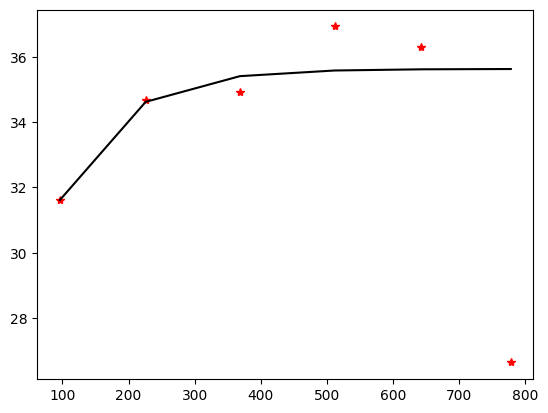

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



,hpdepth,geometry,EC30_ok,EC90_ok
0,101.0,POINT (302315.586 5817535.628),19.293705,22.166589
1,101.0,POINT (302279.551 5817568.072),17.154945,18.714493
2,101.0,POINT (302216.822 5817610.980),16.690158,18.110597
3,101.0,POINT (302162.635 5817665.195),16.993943,20.883035
4,101.0,POINT (302108.713 5817708.313),21.325320,29.065588


In [12]:
hp_ok = hp.copy()
if _HAS_PYKRIGE:
    # EC30
    OK30 = OrdinaryKriging(
        train_xy[:,0], train_xy[:,1], train_ec30, # x and y coordinates of the training points and train_ec30 - measured values at these locations
        variogram_model='exponential', # tells kriging how spatial correlation decreasees with distance
        verbose=True, #  progress messages
        enable_plotting=False
    )
    z30, ss30 = OK30.execute('points', query_xy[:,0], query_xy[:,1])
    hp_ok["EC30_ok"] = np.asarray(z30)

    # EC90
    OK90 = OrdinaryKriging(
        train_xy[:,0], train_xy[:,1], train_ec90,
        variogram_model='exponential',
        verbose=True,
        enable_plotting=True
    )
    z90, ss90 = OK90.execute('points', query_xy[:,0], query_xy[:,1])
    hp_ok["EC90_ok"] = np.asarray(z90)
else:
    print("PyKrige not installed; skipping kriging.")

hp_ok.head()


- Kriging uses the variogram model (exponential) to weigh nearby points when estimating values at unknown locations.
- Points closer to the prediction location get higher weight.
- Variogram helps Kriging understand how fast spatial similarity decreases with distance.
- Without a variogram, kriging wouldn’t know how much trust to place on nearby samples.

EC30 Variogram values:

| Parameter    | Value  | Simple meaning                                                                      |
| ------------ | ------ | ----------------------------------------------------------------------------------- |
| Partial Sill | 22.63  | Variation caused by spatial structure (true spatial patterns)                       |
| Full Sill    | 29.85  | Total variation = spatial variation + measurement/noise                             |
| Nugget       | 7.22   | Variation at zero distance (measurement error or micro-scale variation)             |
| Range        | 778.11 | Distance after which points are no longer correlated (past this, things are random) |


### Save outputs and quick plots
We save the IDW results as a GeoPackage and plot a few quick maps for QA.


In [13]:
# Save an enriched layer (choose which result to save)
out_path = DATA_DIR / "F05_hardpan_enriched_interpolation_python.gpkg"
try:
    hp_out = hp.copy()
    # Attach preferred predictions; here IDW
    if "EC30_idw" in hp_idw.columns:
        hp_out = hp_out.join(hp_idw[["EC30_idw", "EC90_idw"]])
    # Optionally add kNN and OK if available
    if "EC30_knn10" in hp_knn.columns:
        hp_out = hp_out.join(hp_knn[["EC30_knn10", "EC90_knn10"]])
    if _HAS_PYKRIGE and "EC30_ok" in hp_ok.columns:
        hp_out = hp_out.join(hp_ok[["EC30_ok", "EC90_ok"]])

    hp_out.to_file(out_path, driver="GPKG")
    print("Saved:", out_path)
except Exception as e:
    print("Save failed:", e)


Saved: ../data/F05_hardpan_enriched_interpolation_python.gpkg


In [14]:
hp_out.head()

,hpdepth,geometry,EC30_idw,EC90_idw,EC30_knn10,EC90_knn10,EC30_ok,EC90_ok
0,101.0,POINT (302315.586 5817535.628),19.150662,22.108083,18.50,22.12,19.293705,22.166589
1,101.0,POINT (302279.551 5817568.072),16.551399,17.722974,16.54,15.86,17.154945,18.714493
2,101.0,POINT (302216.822 5817610.980),16.756185,17.172624,16.56,16.18,16.690158,18.110597
3,101.0,POINT (302162.635 5817665.195),16.703682,21.355987,16.47,20.17,16.993943,20.883035
4,101.0,POINT (302108.713 5817708.313),20.500344,29.813709,20.10,29.73,21.325320,29.065588


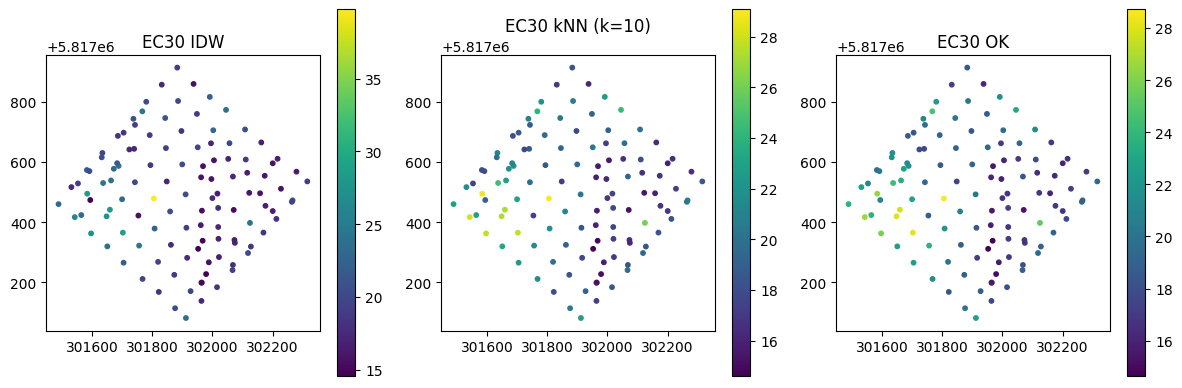

In [15]:
# Quick plots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
if "EC30_idw" in hp_idw.columns:
    hp_idw.plot(column="EC30_idw", ax=axes[0], legend=True, markersize=10)
    axes[0].set_title("EC30 IDW")
if "EC30_knn10" in hp_knn.columns:
    hp_knn.plot(column="EC30_knn10", ax=axes[1], legend=True, markersize=10)
    axes[1].set_title("EC30 kNN (k=10)")
if _HAS_PYKRIGE and "EC30_ok" in hp_ok.columns:
    hp_ok.plot(column="EC30_ok", ax=axes[2], legend=True, markersize=10)
    axes[2].set_title("EC30 OK")
plt.tight_layout(); plt.show()
